In [11]:
# !git clone https://github.com/islab-ai/AITutorial.git

In [12]:
# import os
# os.chdir('/content/AITutorial/RL2')

In [13]:
# install required system dependencies
!apt-get install -y xvfb x11-utils
# # install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* pygame

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (855 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155629 files

In [14]:
from pyvirtualdisplay import Display
import gym
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

display = Display(visible=False, size=(400, 300)) # use False with Xvfb
_=display.start()

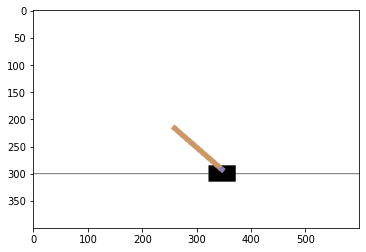

In [ ]:
# create the environment 
env = gym.make("CartPole-v1")
# reset the environment before starting
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

# loop 10 times
for i in range(50):
    # take a random action
    env.step(env.action_space.sample())
    # render the game
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

# close the environment
ipythondisplay.clear_output(wait=True)
env.close()

In [17]:
import numpy as np

def eps_greedy(Q, s, eps=0.1):
    '''
    Epsilon greedy policy : 0~1 사이 Epsilon값으로 Action 결정
    Epsilon 확률로 Random action 선택,
    1-Epsiilon확률로는 최상의 결과를 냈던 Action 선택
    '''
    if np.random.uniform(0,1) < eps:
        # Choose a random action
        return np.random.randint(Q.shape[1])
    else:
        # Choose the action of a greedy policy
        return greedy(Q, s)

In [18]:
def greedy(Q, s):
    '''
    Greedy policy : Q function (Action-state value) 값이 가장 높았던 action 선택
    '''
    return np.argmax(Q[s])

In [19]:
def run_episodes(env, Q, num_episodes=100, to_print=False):
    '''
    Run some episodes to test the policy
    '''
    tot_rew = []
    state = env.reset()

    for _ in range(num_episodes):
        done = False
        game_rew = 0

        while not done:
            # select a greedy action
            next_state, rew, done, _ = env.step(greedy(Q, state))

            state = next_state
            game_rew += rew 
            if done:
                state = env.reset()
                tot_rew.append(game_rew)

    if to_print:
        print('Mean score: %.3f of %i games!'%(np.mean(tot_rew), num_episodes))

    return np.mean(tot_rew)

In [20]:
def Q_learning(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    nA = env.action_space.n
    nS = env.observation_space.n

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0
        
        # decay the epsilon value until it reaches the threshold of 0.01
        if eps > 0.01:
            eps -= eps_decay

        # loop the main body until the environment stops
        while not done:
            # select an action following the eps-greedy policy
            action = eps_greedy(Q, state, eps)

            next_state, rew, done, _ = env.step(action) # Take one step in the environment

            # Q-learning update the state-action value (get the max Q value for the next state)
            Q[state][action] = Q[state][action] + lr*(rew + gamma*np.max(Q[next_state]) - Q[state][action])

            state = next_state
            tot_rew += rew
            if done:
                games_reward.append(tot_rew)

        # Test the policy every 300 episodes and print the results
        if (ep % 300) == 0:
            test_rew = run_episodes(env, Q, 1000)
            print("Episode:{:5d}  Eps:{:2.4f}  Rew:{:2.4f}".format(ep, eps, test_rew))
            test_rewards.append(test_rew)
            
    return Q


In [21]:
def SARSA(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    nA = env.action_space.n
    nS = env.observation_space.n

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0

        # decay the epsilon value until it reaches the threshold of 0.01
        if eps > 0.01:
            eps -= eps_decay


        action = eps_greedy(Q, state, eps) 

        # loop the main body until the environment stops
        while not done:
            next_state, rew, done, _ = env.step(action) # Take one step in the environment

            # choose the next action (needed for the SARSA update)
            next_action = eps_greedy(Q, next_state, eps) 
            # SARSA update
            Q[state][action] = Q[state][action] + lr*(rew + gamma*Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            tot_rew += rew
            if done:
                games_reward.append(tot_rew)

        # Test the policy every 300 episodes and print the results
        if (ep % 300) == 0:
            test_rew = run_episodes(env, Q, 1000)
            print("Episode:{:5d}  Eps:{:2.4f}  Rew:{:2.4f}".format(ep, eps, test_rew))
            test_rewards.append(test_rew)

    return Q


In [22]:
import gym

env = gym.make('Taxi-v3')
    
Q_qlearning = Q_learning(env, lr=.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)



Episode:    0  Eps:0.3990  Rew:-207.2000
Episode:  300  Eps:0.0990  Rew:-199.3550
Episode:  600  Eps:0.0100  Rew:-178.0340
Episode:  900  Eps:0.0100  Rew:-137.0160
Episode: 1200  Eps:0.0100  Rew:-87.8180
Episode: 1500  Eps:0.0100  Rew:-68.0670
Episode: 1800  Eps:0.0100  Rew:-46.4170
Episode: 2100  Eps:0.0100  Rew:-22.7670
Episode: 2400  Eps:0.0100  Rew:-20.6320
Episode: 2700  Eps:0.0100  Rew:2.6060
Episode: 3000  Eps:0.0100  Rew:2.2920
Episode: 3300  Eps:0.0100  Rew:6.0170
Episode: 3600  Eps:0.0100  Rew:6.8730
Episode: 3900  Eps:0.0100  Rew:7.9710
Episode: 4200  Eps:0.0100  Rew:7.9730
Episode: 4500  Eps:0.0100  Rew:7.7440
Episode: 4800  Eps:0.0100  Rew:7.7510


In [23]:
Q_sarsa = SARSA(env, lr=.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)

Episode:    0  Eps:0.3990  Rew:-250.2110
Episode:  300  Eps:0.0990  Rew:-225.7910
Episode:  600  Eps:0.0100  Rew:-181.4820
Episode:  900  Eps:0.0100  Rew:-185.2700
Episode: 1200  Eps:0.0100  Rew:-119.8860
Episode: 1500  Eps:0.0100  Rew:-48.7530
Episode: 1800  Eps:0.0100  Rew:-34.2700
Episode: 2100  Eps:0.0100  Rew:-42.7040
Episode: 2400  Eps:0.0100  Rew:-5.9920
Episode: 2700  Eps:0.0100  Rew:-0.2400
Episode: 3000  Eps:0.0100  Rew:4.1540
Episode: 3300  Eps:0.0100  Rew:4.1200
Episode: 3600  Eps:0.0100  Rew:5.6940
Episode: 3900  Eps:0.0100  Rew:7.4250
Episode: 4200  Eps:0.0100  Rew:7.9170
Episode: 4500  Eps:0.0100  Rew:7.9890
Episode: 4800  Eps:0.0100  Rew:8.0140
